<a href="https://colab.research.google.com/github/Andrey-Epifanov-k721/conv_networks/blob/master/GAN_Flickr_Faces_v10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/archive_face.zip

Archive:  /content/drive/MyDrive/archive_face.zip
  inflating: faces_dataset_small/00055.png  
  inflating: faces_dataset_small/00237.png  
  inflating: faces_dataset_small/00240.png  
  inflating: faces_dataset_small/00241.png  
  inflating: faces_dataset_small/00242.png  
  inflating: faces_dataset_small/00243.png  
  inflating: faces_dataset_small/00244.png  
  inflating: faces_dataset_small/00245.png  
  inflating: faces_dataset_small/00246.png  
  inflating: faces_dataset_small/00247.png  
  inflating: faces_dataset_small/00248.png  
  inflating: faces_dataset_small/00249.png  
  inflating: faces_dataset_small/00253.png  
  inflating: faces_dataset_small/00255.png  
  inflating: faces_dataset_small/00257.png  
  inflating: faces_dataset_small/00258.png  
  inflating: faces_dataset_small/00259.png  
  inflating: faces_dataset_small/00260.png  
  inflating: faces_dataset_small/00261.png  
  inflating: faces_dataset_small/00262.png  
  inflating: faces_dataset_small/00263.png  
  inf

In [3]:
DATA_DIR = './faces_dataset_small/'

В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [4]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from torchvision import datasets, transforms

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [5]:
from torchvision.transforms.functional import normalize
import os
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, root_dir, image_size):
        self.root_dir = root_dir
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]
        self.transform = tt.Compose([
            tt.Resize(image_size),
            tt.CenterCrop(image_size),
            tt.ToTensor(),
            tt.Normalize(*stats)
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_file = self.image_files[index]
        image_path = os.path.join(self.root_dir, image_file)
        image = Image.open(image_path)
        image = self.transform(image)
        return image

def get_dataloader(image_size, batch_size):
    dataset = CustomDataset(DATA_DIR, image_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader, dataset



In [6]:
image_size = 128
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [7]:
train_data, dataset = get_dataloader(image_size, batch_size)

In [162]:
print(dataloader.batch_size)

128


In [8]:
# кол-во картинок в датасете / batch_size
len(train_data)

25

In [96]:
# кол-во картинок в датасете
len(dataset)

3143

In [146]:
len(dataloader)

25

In [10]:
# Получение количества пакетов в DataLoader
num_batches = len(train_data)

# Получение общего количества образцов в DataLoader
num_samples = len(train_data.dataset)

print("Количество пакетов:", num_batches)
print("Количество образцов:", num_samples)

Количество пакетов: 25
Количество образцов: 3143


In [11]:
dataloader, _ = get_dataloader(image_size, batch_size)

In [12]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_images(dataloader):
    # Получаем пакет изображений из dataloader
    images = next(iter(dataloader))

    # Создаем сетку изображений
    grid = vutils.make_grid(images[:25], nrow=5, normalize=True)

    # Выводим сетку на экран
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


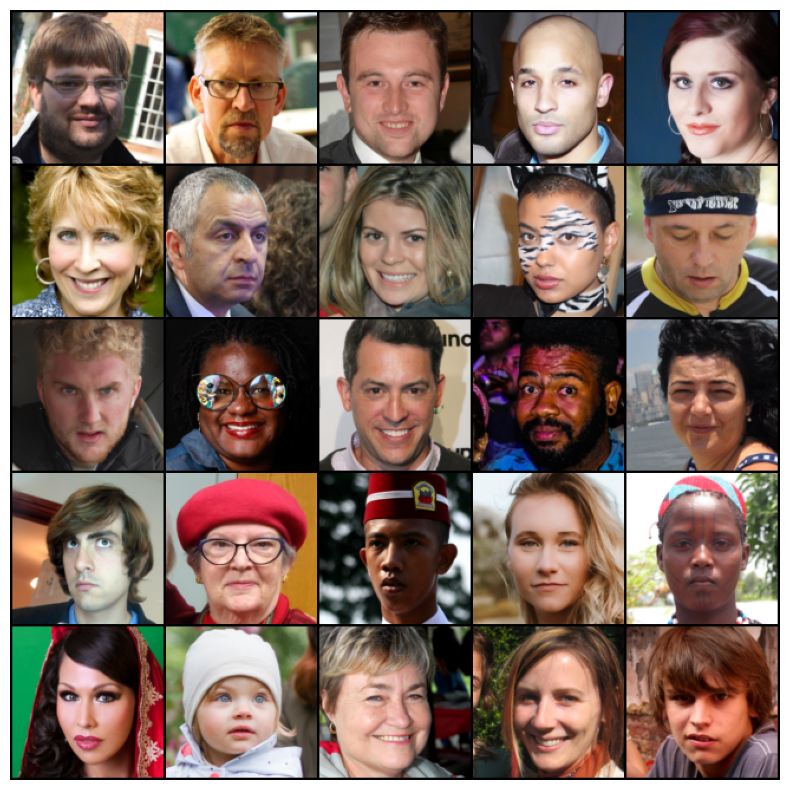

In [13]:
show_images(dataloader)


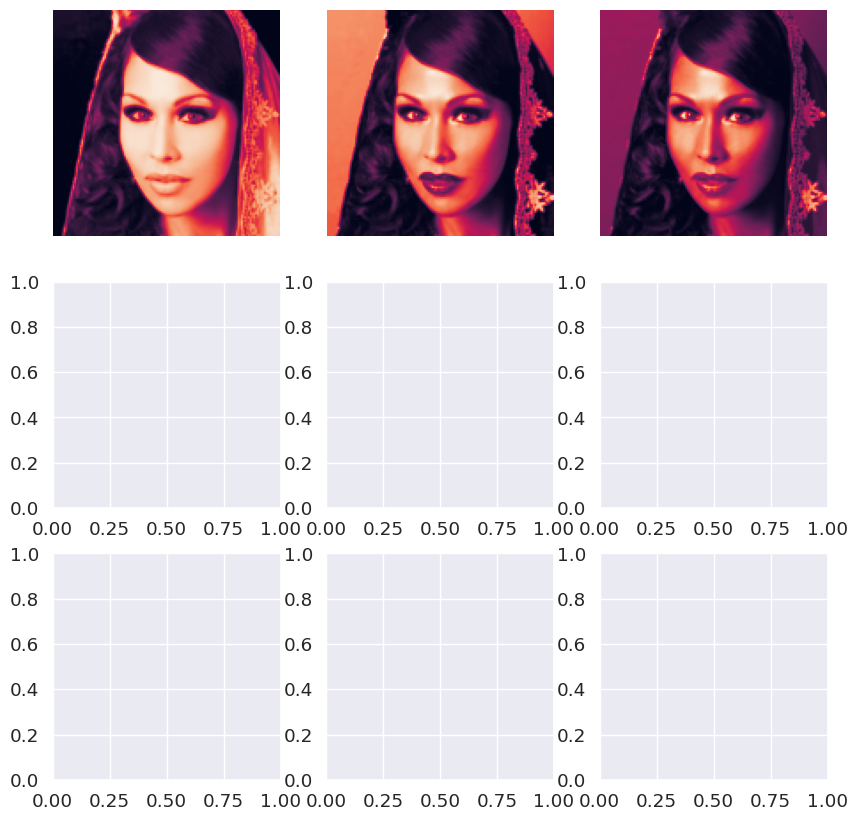

In [14]:
import matplotlib.pyplot as plt

# Получите первые 25 изображений из dataset
images = dataset[0]

# Создайте сетку 5x5 для отображения изображений
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Переберите изображения и отобразите их на соответствующих осях
for i, image in enumerate(images):
    ax = axes[i // 5, i % 5]
    ax.imshow(image)
    ax.axis('off')

# Показать сетку изображений
plt.show()


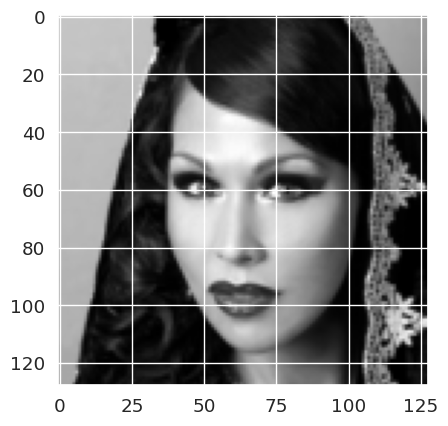

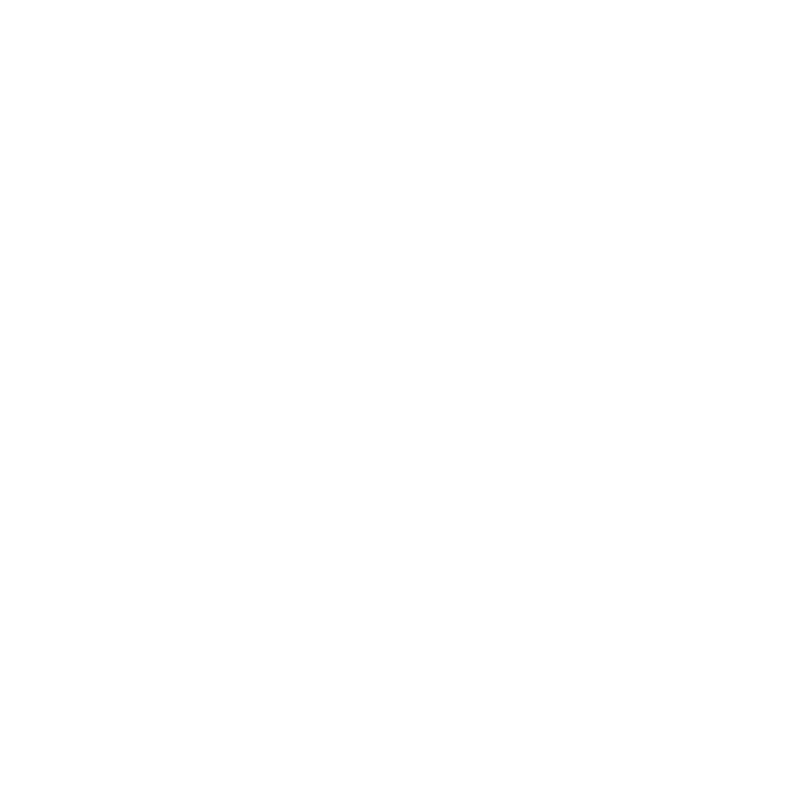

In [15]:
    images = dataset[0]
    grid = vutils.make_grid(images[1], nrow=5, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.show()

In [16]:
#TODO: build dataloader and transfer it to device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [17]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [18]:
# output_size = (input_size + 2 * padding - kernel_size) / stride + 1
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(8),
    nn.LeakyReLU(0.2, inplace=False),
    # out: 64 x 64 x 64

    nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.2, inplace=False),
    # out: 128 x 32 x 32

    nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=False),
    # out: 256 x 16 x 16

    nn.Conv2d(32, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=False),
    # out: 512 x 8 x 8

    nn.Conv2d(128, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=False),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [19]:
latent_size = 512

In [20]:
# output_size = (input_size - 1) * stride - 2 * padding + kernel_size
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 32 x 64 x 64


    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

In [21]:
generator = to_device(generator, device)

In [22]:
discriminator = to_device(discriminator, device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [23]:
lr = 0.0002

model = {"discriminator": discriminator, "generator": generator}

criterion = {"discriminator": nn.BCELoss(), "generator": nn.BCELoss()}
# criterion = {"discriminator": nn.MSELoss(), "generator": nn.MSELoss()}
# criterion = {"discriminator": nn.L1Loss(), "generator": nn.L1Loss()}


In [24]:
# Загрузим обученную модель если до этого уже обучали ее

# Укажите путь к файлу с сохраненными весами
path_g = '/content/drive/MyDrive/model_GAN_Faces_generator_v5.pth'
path_d = '/content/drive/MyDrive/model_GAN_Faces_discriminator_v5.pth'

# Загрузите веса в модель
model["generator"].load_state_dict(torch.load(path_g))
model["discriminator"].load_state_dict(torch.load(path_d))

<All keys matched successfully>

In [ ]:
# Метод train() в PyTorch используется для установки режима обучения модели.
# Когда модель находится в режиме обучения (model.train()), некоторые слои, такие
# как Dropout или Batch Normalization, могут работать по-разному, чем во время
# оценки или инференса.

# Вызов model["discriminator"].train() и model["generator"].train() в функции
# fit() позволяет установить оба этих модуля в режим обучения перед выполнением
# обучения и обновлением параметров. Это важно, чтобы модели корректно
# выполняли обучение, используя оптимизатор и потери, указанные в функции fit().

In [ ]:
# import torch.optim as optim

# def fit(model, criterion, epochs, lr):
#     # переводим нейронные сети в режим обучения
#     model["discriminator"].train()
#     model["generator"].train()

#     # присваиваем модели дискриминатора и генератора к переменным для удобства
#     # discriminator = model["discriminator"]
#     # generator = model["generator"]

#     # нужны ли?
#     # Оптимизаторы для обновления параметров дискриминатора и генератора
#     optimizer = {
#         "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
#                                           lr=lr, betas=(0.5, 0.999)),
#         "generator": torch.optim.Adam(model["generator"].parameters(),
#                                       lr=lr, betas=(0.5, 0.999))}

In [25]:
epochs = 30

In [26]:
optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))}

In [ ]:
losses_d = []  # Список для хранения значений loss дискриминатора
losses_g = []  # Список для хранения значений loss генератора
real_scores = []  # Список для хранения значений скора на реальных изображениях
fake_scores = []  # Список для хранения значений скора на фейковых изображениях

for epoch in range(epochs):
    loss_d_per_epoch = []
    loss_g_per_epoch = []
    real_score_per_epoch = []
    fake_score_per_epoch = []

    for real_images in tqdm(dataloader):
        # Обучение дискриминатора
        optimizer['discriminator'].zero_grad()

        real_preds = model["discriminator"](real_images.to(device))
        real_targets = torch.ones(real_images.size(0), 1, device=device)*0.95
        real_loss = criterion["discriminator"](real_preds, real_targets)
        cur_real_score = torch.mean(real_preds).item()

        latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = model["generator"](latent)
        fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
        fake_preds = model["discriminator"](fake_images)
        fake_loss = criterion["discriminator"](fake_preds, fake_targets)
        cur_fake_score = torch.mean(fake_preds).item()

        loss_d = real_loss + fake_loss
        loss_d.backward()
        optimizer["discriminator"].step()
        loss_d_per_epoch.append(loss_d.item())

        # Обучение генератора
        optimizer["generator"].zero_grad()

        latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = model["generator"](latent)
        preds = model["discriminator"](fake_images)
        targets = torch.ones(batch_size, 1, device=device)
        loss_g = criterion["generator"](preds, targets)
        loss_g.backward()
        optimizer["generator"].step()
        loss_g_per_epoch.append(loss_g.item())

    # Сохранение значений loss и скоров в текущей эпохе
    losses_d.append(torch.mean(torch.FloatTensor(loss_d_per_epoch)))
    losses_g.append(torch.mean(torch.FloatTensor(loss_g_per_epoch)))
    real_scores.append(torch.mean(torch.FloatTensor(real_score_per_epoch)))
    fake_scores.append(torch.mean(torch.FloatTensor(fake_score_per_epoch)))

    # Вывод информации о прогрессе обучения
    print(f"Epoch [{epoch+1}/{epochs}] - Discriminator Loss: {losses_d[-1]:.4f} - Generator Loss: {losses_g[-1]:.4f}")


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/30] - Discriminator Loss: 0.3747 - Generator Loss: 3.2233


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/30] - Discriminator Loss: 0.3955 - Generator Loss: 3.2660


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/30] - Discriminator Loss: 0.3529 - Generator Loss: 3.3248


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/30] - Discriminator Loss: 0.3528 - Generator Loss: 3.3777


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/30] - Discriminator Loss: 0.3401 - Generator Loss: 3.4185


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6/30] - Discriminator Loss: 0.4216 - Generator Loss: 3.4522


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7/30] - Discriminator Loss: 0.3854 - Generator Loss: 3.5742


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [8/30] - Discriminator Loss: 0.3194 - Generator Loss: 3.4453


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [9/30] - Discriminator Loss: 0.3180 - Generator Loss: 3.4549


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [10/30] - Discriminator Loss: 0.3175 - Generator Loss: 3.5102


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [11/30] - Discriminator Loss: 0.3324 - Generator Loss: 3.5588


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [12/30] - Discriminator Loss: 0.3367 - Generator Loss: 3.5427


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [13/30] - Discriminator Loss: 0.3202 - Generator Loss: 3.6336


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [14/30] - Discriminator Loss: 0.3144 - Generator Loss: 3.7099


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [15/30] - Discriminator Loss: 0.3172 - Generator Loss: 3.6170


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [16/30] - Discriminator Loss: 0.3056 - Generator Loss: 3.6725


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [17/30] - Discriminator Loss: 1.5591 - Generator Loss: 4.1665


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [18/30] - Discriminator Loss: 0.5476 - Generator Loss: 3.8549


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [19/30] - Discriminator Loss: 0.3742 - Generator Loss: 3.3789


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [20/30] - Discriminator Loss: 0.3199 - Generator Loss: 3.3532


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [21/30] - Discriminator Loss: 0.3007 - Generator Loss: 3.3963


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [22/30] - Discriminator Loss: 0.2879 - Generator Loss: 3.4375


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [23/30] - Discriminator Loss: 0.2822 - Generator Loss: 3.5109


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [24/30] - Discriminator Loss: 0.2776 - Generator Loss: 3.5216


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [25/30] - Discriminator Loss: 0.2754 - Generator Loss: 3.5246


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [26/30] - Discriminator Loss: 0.2708 - Generator Loss: 3.5457


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [27/30] - Discriminator Loss: 0.2739 - Generator Loss: 3.6214


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [28/30] - Discriminator Loss: 0.2693 - Generator Loss: 3.6090


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [29/30] - Discriminator Loss: 0.2700 - Generator Loss: 3.6118


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [30/30] - Discriminator Loss: 0.2760 - Generator Loss: 3.6186


In [ ]:
# torch.cuda.empty_cache()
# Проверка использования памяти GPU
print(torch.cuda.memory_allocated(device))
print(torch.cuda.memory_cached(device))

180517376
882900992


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:416: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [ ]:
from google.colab import drive
import torch

# Укажите путь к файлу на Google Диске, куда хотите сохранить модель
path = '/content/drive/MyDrive/model_GAN_Faces_generator_v5.h5'

# Сохранение модели
torch.save(model["generator"].state_dict(), path)

print("Модель generator успешно сохранена на Google Диск по пути:", path)

Модель generator успешно сохранена на Google Диск по пути: /content/drive/MyDrive/model_GAN_Faces_generator_v5.h5


In [ ]:
# Укажите путь и имя файла для сохранения модели
path = '/content/drive/MyDrive/model_GAN_Faces_generator_v5.pth'
# Сохранение модели
torch.save(model["generator"].state_dict(), path)

In [ ]:
# Укажите путь к файлу на Google Диске, куда хотите сохранить модель
path = '/content/drive/MyDrive/model_GAN_Faces_discriminator_v5.h5'

# Сохранение модели
torch.save(model["discriminator"].state_dict(), path)

print("Модель discriminator успешно сохранена на Google Диск по пути:", path)

Модель discriminator успешно сохранена на Google Диск по пути: /content/drive/MyDrive/model_GAN_Faces_discriminator_v5.h5


In [ ]:
# Укажите путь и имя файла для сохранения модели
path = '/content/drive/MyDrive/model_GAN_Faces_discriminator_v5.pth'
# Сохранение модели
torch.save(model["discriminator"].state_dict(), path)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

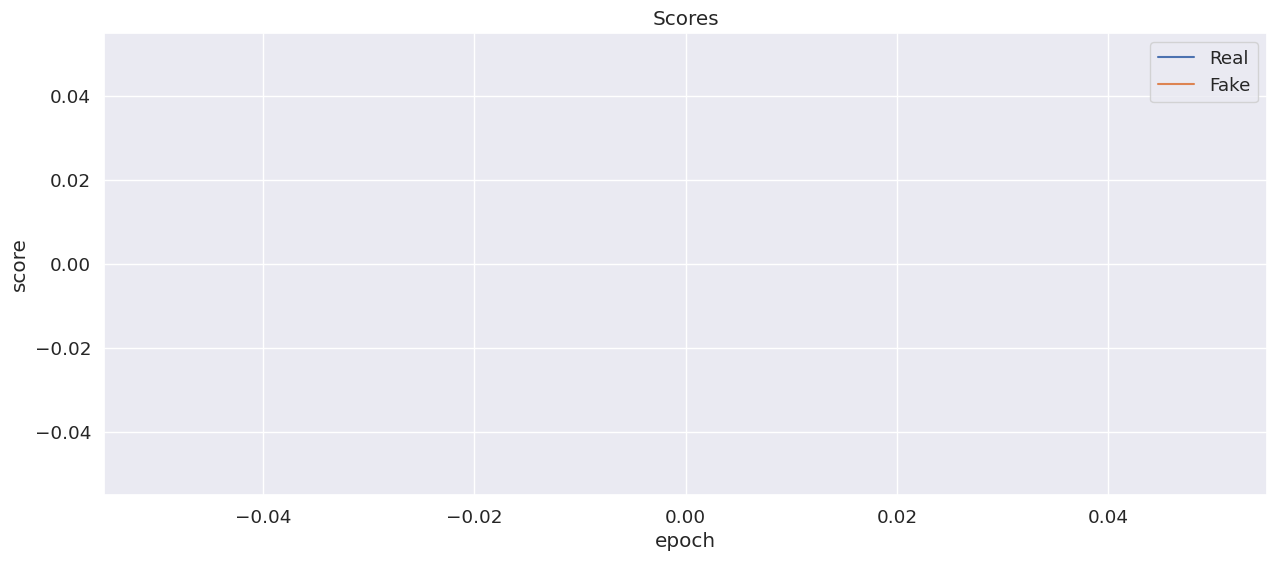

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

# Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [49]:
n_images = 1

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
generated_img = model["generator"](fixed_latent)

In [31]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_images(generated):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.set_xticks([])
    ax.set_yticks([])

    # Нормализация значений пикселей к диапазону [0, 1]
    normalized_img = vutils.make_grid(generated, normalize=True)

    ax.imshow(normalized_img.permute(1, 2, 0).cpu().detach().numpy())
    plt.show()

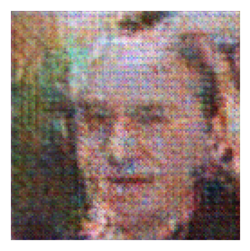

In [50]:
show_images(generated_img)

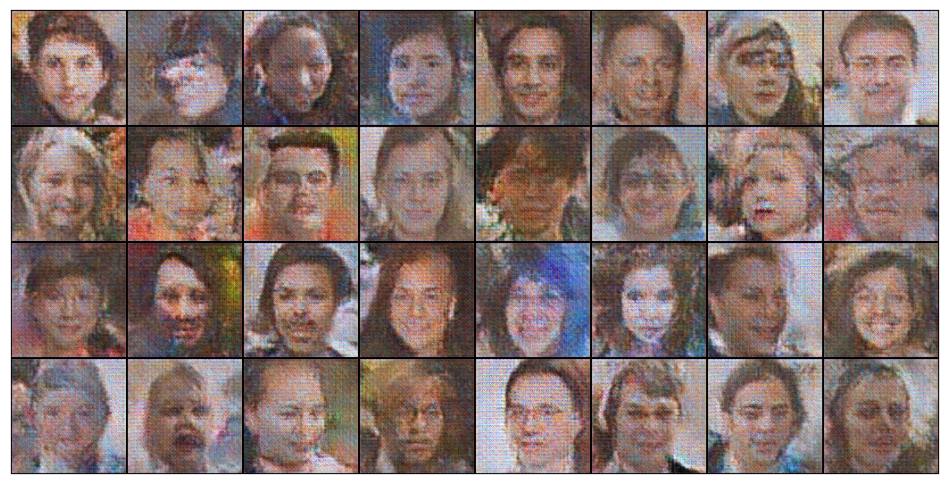

In [51]:
n_images = 32

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
generated_img = model["generator"](fixed_latent)
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_images(generated):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([])
    ax.set_yticks([])

    # Нормализация значений пикселей к диапазону [0, 1]
    normalized_img = vutils.make_grid(generated, normalize=True)

    ax.imshow(normalized_img.permute(1, 2, 0).cpu().detach().numpy())
    plt.show()

show_images(generated_img)


# Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [181]:
fake_images = []
for i in range(int(len(dataset))):
    fixed_latent = torch.FloatTensor(1, latent_size, 1, 1).uniform_(-1, 1).to(device)
    generated_images = model["generator"](fixed_latent).detach()
    fake_images.append(generated_images)

In [182]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Конвертируем список gen_images в тензор
gen_images_tensor = torch.cat(fake_images, dim=0)

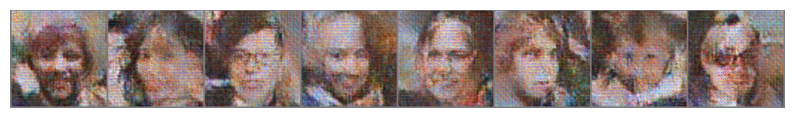

In [191]:
# проверим, что изображения на экране выглядят нормально
# Создаем сетку изображений
grid_image = vutils.make_grid(gen_images_tensor[0:8], nrow=int(len(gen_images)))

normalized_img = vutils.make_grid(grid_image, normalize=True)

# Преобразуем тензор в массив NumPy
fake_images = normalized_img.cpu().numpy()

# Отображаем сетку изображений
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(fake_images, (1, 2, 0)))
plt.axis('off')
plt.show()


In [184]:
data = []

for batch in dataloader:
    data.append(batch)


In [185]:
real_im = torch.cat(data, dim=0)
real_images = to_device(real_im, device=device)

In [186]:
# Создаем тензор меток класса 0 с размером, соответствующим количеству сгенерированных изображений
fake_labels = torch.zeros(len(gen_images))

# Создаем тензор меток класса 1 с размером, соответствующим количеству сгенерированных изображений
real_labels = torch.ones(len(gen_images))

In [187]:
# Объединить фейковые и настоящие изображения и метки
all_images = torch.cat((gen_images_tensor, real_images), dim=0)
all_labels = torch.cat((fake_labels, real_labels), dim=0)

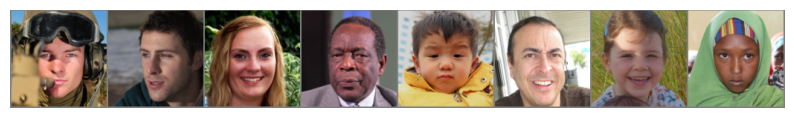

In [192]:
# проверим, что изображения на экране выглядят нормально
# Создаем сетку изображений
grid_image = vutils.make_grid(real_images[0:8], nrow=int(len(gen_images)))

normalized_img = vutils.make_grid(grid_image, normalize=True)

# Преобразуем тензор в массив NumPy
fake_images = normalized_img.cpu().numpy()

# Отображаем сетку изображений
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(fake_images, (1, 2, 0)))
plt.axis('off')
plt.show()

_____________________________________________________

In [ ]:
import torch
from sklearn.model_selection import train_test_split

# Создайте пустые списки для хранения данных и меток классов
data = []
labels = []

# Пройдитесь по каждому элементу в dataloader и присвойте метку класса "1"
for i in dataset:
# for batch_data in range(10):
    data.append(i)
    labels.append(torch.ones(i.shape[0]))  # Присваиваем метку класса "1"

# Объедините данные и метки классов
X = torch.cat(data, dim=0)
y = torch.cat(labels, dim=0)

# Разделите данные на обучающую и тестовую выборки
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10, random_state=42)

In [ ]:
import torch

# Создайте пустые списки для хранения данных и меток классов
data = []
labels = []

# Пройдитесь по каждому элементу в dataset и присвойте метку класса "1"
for i in dataset:
    data.append(i)
    labels.append(torch.ones(1))  # Присваиваем метку класса "1"

# Объедините данные и метки классов
X = torch.cat(data, dim=0)
y = torch.cat(labels, dim=0)

print(X.size())


torch.Size([9429, 128, 128])


In [ ]:
# выносит ОЗУ
import os
from PIL import Image
import torch
import torchvision.transforms as transforms

# DATA_DIR = "путь_к_директории_с_изображениями"

# Создание пустых списков для данных и меток классов
data = []
labels = []

# Перебор файлов изображений в директории
for filename in os.listdir(DATA_DIR):
    # Проверка, является ли файл изображением
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Загрузка изображения с помощью PIL
        image = Image.open(os.path.join(DATA_DIR, filename))
        # Преобразование изображения в тензор с помощью ToTensor()
        tensor_image = transforms.ToTensor()(image)
        # Добавление изображения в список данных
        data.append(tensor_image)
        # Присвоение метки класса 1
        labels.append(torch.ones(1))

# Объединение данных и меток классов
X = torch.cat(data, dim=0)
y = torch.cat(labels, dim=0)

In [ ]:
print(X.size())
print(y.size())

In [ ]:
# # Сгенерируйте фейковые изображения, количество которых равно количеству настоящих изображений в обучающей выборке.
# n_images = len(X_train)

# fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
# generated_img = model["generator"](fixed_latent)

In [ ]:
n_images = len(dataset)
fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)
fake_labels = torch.zeros(len(dataset))

In [ ]:
print(fake_images.size())

In [ ]:
# # Объедините настоящие и фейковые изображения, а также их метки классов:
# X_combined = np.concatenate((X_train, fake_images))
# y_combined = np.concatenate((y_train, fake_labels))

In [ ]:
X = torch.cat((real_images, fake_images), dim=0)
y = torch.cat((real_labels, fake_labels))

In [ ]:
real_images = []
real_labels = []

for batch_data, batch_labels in dataloader:
    real_images.append(batch_data)
    real_labels.append(batch_labels)

real_images = torch.cat(real_images, dim=0)
real_labels = torch.tensor(real_labels)


In [ ]:
import numpy as np

# Получите случайную перестановку индексов
indices = np.random.permutation(len(X))

# Используйте перестановку для перемешивания данных и меток
X = X[indices]
y = y[indices]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10, random_state=42)

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

# Изменение дискриминатора на предобученной модели

In [ ]:
# output_size = (input_size + 2 * padding - kernel_size) / stride + 1
discriminator_new = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(8),
    nn.LeakyReLU(0.2, inplace=False),
    # out: 64 x 64 x 64

    nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.2, inplace=False),
    # out: 128 x 32 x 32

    nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=False),
    # out: 256 x 16 x 16

    nn.Conv2d(32, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=False),
    # out: 512 x 8 x 8

    nn.Conv2d(128, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=False),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
latent_size = 512

In [ ]:
# создадим новый последний слой генератора чтобы в дальнейшем скачать уже
# обученную сеть генератора и дообучить новый генератор.
# Якобы последний добавленный слой предаст четкость генерируемому изображению.
# output_size = (input_size - 1) * stride - 2 * padding + kernel_size
generator_new = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 32 x 64 x 64

    nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 32 x 128 x 128

    # output_size = (input_size + 2 * padding - kernel_size) / stride + 1
    nn.Conv2d(in_channels=32, out_channels=3, kernel_size=5, stride=1, padding=2, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

In [ ]:
generator_new = to_device(generator_new, device)
discriminator_new = to_device(discriminator_new, device)

In [ ]:
lr = 0.0002

model = {"discriminator_new": discriminator_new, "generator_new": generator_new}

criterion = {"discriminator_new": nn.BCELoss(), "generator_new": nn.BCELoss()}
# criterion = {"discriminator": nn.MSELoss(), "generator_new": nn.MSELoss()}
# criterion = {"discriminator": nn.L1Loss(), "generator_new": nn.L1Loss()}


In [ ]:
# # Загрузим обученную модель если до этого уже обучали ее

# # Укажите путь к файлу с сохраненными весами
# path_g = '/content/drive/MyDrive/model_GAN_Faces_generator_v4.pth'
# path_d = '/content/drive/MyDrive/model_GAN_Faces_discriminator_v4.pth'

# # Загрузите веса в модель
# model["generator_new"].load_state_dict(torch.load(path_g))
# model["discriminator"].load_state_dict(torch.load(path_d))

In [ ]:
# Загрузим обученную модель дискриминатора

# Укажите путь к файлу с сохраненными весами
path_d = '/content/drive/MyDrive/model_GAN_Faces_discriminator_v4.pth'

# Загрузите веса в модель дискриминатора
model["discriminator_new"].load_state_dict(torch.load(path_d))


<All keys matched successfully>

In [ ]:
# Загрузим обученную модель генератора.
# Если возникает ошибка, то необходимо выполнить код по изменению архитектуры - добавить веса
path_g = '/content/drive/MyDrive/model_GAN_Faces_generator_v4.pth'
model["generator_new"].load_state_dict(torch.load(path_g))

### Далее код который необходим при изменении архитектуры модели генератора

Здесь происходит загрузка весов из старой модели + добавляются новые рандомные веса к новому добавленному слою генератора.

In [ ]:
# код проверки отсутствия ключей после изменения архитектуры модели генератора
path_g = '/content/drive/MyDrive/model_GAN_Faces_generator_v4.pth'
state_dict = torch.load(path_g)
missing_keys = set(model["generator_new"].state_dict().keys()) - set(state_dict.keys())
print("Missing keys in state_dict:", missing_keys)


Missing keys in state_dict: {'16.running_mean', '18.weight', '16.bias', '16.running_var', '16.num_batches_tracked', '16.weight'}


In [ ]:
# # добавление информации о последнем слое nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, stride=1, padding=2, bias=False),
# model["generator_new"] = model["generator"].add_module("16", nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, stride=1, padding=2, bias=False))
# # state_dict.pop("18.weight")
# # state_dict["new_key.weight"] = state_dict.pop("16.weight")


In [ ]:
state_dict["16.weight"] = torch.rand(size=(128, 128)).cuda().float()
state_dict["18.weight"] = torch.rand(size=(128, 128)).cuda().float()

In [ ]:
# state_dict["16.weight"] = torch.rand(size=(128,), device=torch.device("cuda")).float()
# state_dict["18.weight"] = torch.rand(size=(128,), device=torch.device("cuda")).float()

In [ ]:
# код проверки отсутствия ключей после изменения архитектуры модели генератора
missing_keys = set(model["generator_new"].state_dict().keys()) - set(state_dict.keys())
print("Missing keys in state_dict:", missing_keys)

Missing keys in state_dict: {'16.running_var', '16.bias', '16.running_mean', '16.num_batches_tracked'}


In [ ]:
print("Keys in state_dict:", state_dict.keys())

Keys in state_dict: odict_keys(['0.weight', '1.weight', '1.bias', '1.running_mean', '1.running_var', '1.num_batches_tracked', '3.weight', '4.weight', '4.bias', '4.running_mean', '4.running_var', '4.num_batches_tracked', '6.weight', '7.weight', '7.bias', '7.running_mean', '7.running_var', '7.num_batches_tracked', '9.weight', '10.weight', '10.bias', '10.running_mean', '10.running_var', '10.num_batches_tracked', '12.weight', '13.weight', '13.bias', '13.running_mean', '13.running_var', '13.num_batches_tracked', '15.weight', '16.weight', '18.weight'])


In [ ]:
state_dict_new = model["generator_new"].state_dict()
print("Keys in state_dict:", state_dict_new.keys())

Keys in state_dict: odict_keys(['0.weight', '1.weight', '1.bias', '1.running_mean', '1.running_var', '1.num_batches_tracked', '3.weight', '4.weight', '4.bias', '4.running_mean', '4.running_var', '4.num_batches_tracked', '6.weight', '7.weight', '7.bias', '7.running_mean', '7.running_var', '7.num_batches_tracked', '9.weight', '10.weight', '10.bias', '10.running_mean', '10.running_var', '10.num_batches_tracked', '12.weight', '13.weight', '13.bias', '13.running_mean', '13.running_var', '13.num_batches_tracked', '15.weight', '16.weight', '16.bias', '16.running_mean', '16.running_var', '16.num_batches_tracked', '18.weight'])


In [ ]:
# Загрузим веса в модель генератора
model["generator_new"].load_state_dict(state_dict_new)

<All keys matched successfully>

In [ ]:
# код проверки отсутствия ключей после изменения архитектуры модели генератора
missing_keys = set(model["generator_new"].state_dict().keys()) - set(state_dict_new.keys())
print("Missing keys in state_dict:", missing_keys)

Missing keys in state_dict: set()


# Обучение модели с измененным генератором

In [ ]:
optimizer = {
        "discriminator_new": torch.optim.Adam(model["discriminator_new"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator_new": torch.optim.Adam(model["generator_new"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))}

In [ ]:
print(model['generator_new'])

Sequential(
  (0): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_r

In [ ]:
# установим все параметры модели в режим обучения (вычисление градиентов для всех парамтеров)
for module in model.values():
    for param in module.parameters():
        param.requires_grad = True

In [ ]:
# # Заморозить все слои кроме последних двух слоев ConvTranspose2d и Conv2d (атрибуты называются по индексам)
for param in model['generator_new'][:-3].parameters():
    param.requires_grad = False

In [ ]:
for name, param in model['generator_new'].named_parameters():
    print(f'Parameter: {name}, Requires Grad: {param.requires_grad}')

Parameter: 0.weight, Requires Grad: False
Parameter: 1.weight, Requires Grad: False
Parameter: 1.bias, Requires Grad: False
Parameter: 3.weight, Requires Grad: False
Parameter: 4.weight, Requires Grad: False
Parameter: 4.bias, Requires Grad: False
Parameter: 6.weight, Requires Grad: False
Parameter: 7.weight, Requires Grad: False
Parameter: 7.bias, Requires Grad: False
Parameter: 9.weight, Requires Grad: False
Parameter: 10.weight, Requires Grad: False
Parameter: 10.bias, Requires Grad: False
Parameter: 12.weight, Requires Grad: False
Parameter: 13.weight, Requires Grad: False
Parameter: 13.bias, Requires Grad: False
Parameter: 15.weight, Requires Grad: False
Parameter: 16.weight, Requires Grad: False
Parameter: 16.bias, Requires Grad: False
Parameter: 18.weight, Requires Grad: True


In [ ]:
for param in model['discriminator_new'][:-3].parameters():
    param.requires_grad = False

In [ ]:
for name, param in model['discriminator_new'].named_parameters():
    print(f'Parameter: {name}, Requires Grad: {param.requires_grad}')

Parameter: 0.weight, Requires Grad: False
Parameter: 1.weight, Requires Grad: False
Parameter: 1.bias, Requires Grad: False
Parameter: 3.weight, Requires Grad: False
Parameter: 4.weight, Requires Grad: False
Parameter: 4.bias, Requires Grad: False
Parameter: 6.weight, Requires Grad: False
Parameter: 7.weight, Requires Grad: False
Parameter: 7.bias, Requires Grad: False
Parameter: 9.weight, Requires Grad: False
Parameter: 10.weight, Requires Grad: False
Parameter: 10.bias, Requires Grad: False
Parameter: 12.weight, Requires Grad: False
Parameter: 13.weight, Requires Grad: False
Parameter: 13.bias, Requires Grad: False
Parameter: 15.weight, Requires Grad: True


In [ ]:
epochs = 30

In [ ]:
losses_d = []  # Список для хранения значений loss дискриминатора
losses_g = []  # Список для хранения значений loss генератора
real_scores = []  # Список для хранения значений скора на реальных изображениях
fake_scores = []  # Список для хранения значений скора на фейковых изображениях

for epoch in range(epochs):
    loss_d_per_epoch = []
    loss_g_per_epoch = []
    real_score_per_epoch = []
    fake_score_per_epoch = []

    for real_images in tqdm(dataloader):
        # Обучение дискриминатора
        optimizer['discriminator_new'].zero_grad()

        real_preds = model["discriminator_new"](real_images.to(device))
        real_targets = torch.ones(real_images.size(0), 1, device=device)*0.9
        real_loss = criterion["discriminator_new"](real_preds, real_targets)
        cur_real_score = torch.mean(real_preds).item()

        latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = model["generator_new"](latent)
        fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
        fake_preds = model["discriminator_new"](fake_images)
        fake_loss = criterion["discriminator_new"](fake_preds, fake_targets)
        cur_fake_score = torch.mean(fake_preds).item()

        loss_d = real_loss + fake_loss
        loss_d.backward()
        optimizer["discriminator_new"].step()
        loss_d_per_epoch.append(loss_d.item())

        # Обучение генератора
        optimizer["discriminator_new"].zero_grad()

        latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = model["generator_new"](latent)
        preds = model["discriminator_new"](fake_images)
        targets = torch.ones(batch_size, 1, device=device)
        loss_g = criterion["generator_new"](preds, targets)
        loss_g.backward()
        optimizer["generator_new"].step()
        loss_g_per_epoch.append(loss_g.item())

    # Сохранение значений loss и скоров в текущей эпохе
    losses_d.append(torch.mean(torch.FloatTensor(loss_d_per_epoch)))
    losses_g.append(torch.mean(torch.FloatTensor(loss_g_per_epoch)))
    real_scores.append(torch.mean(torch.FloatTensor(real_score_per_epoch)))
    fake_scores.append(torch.mean(torch.FloatTensor(fake_score_per_epoch)))

    # Вывод информации о прогрессе обучения
    print(f"Epoch [{epoch+1}/{epochs}] - Discriminator Loss: {losses_d[-1]:.4f} - Generator Loss: {losses_g[-1]:.4f}")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/30] - Discriminator Loss: 0.4389 - Generator Loss: 3.5087


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/30] - Discriminator Loss: 0.3762 - Generator Loss: 4.6682


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/30] - Discriminator Loss: 0.3628 - Generator Loss: 5.0996


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/30] - Discriminator Loss: 0.3567 - Generator Loss: 5.2869


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/30] - Discriminator Loss: 0.3544 - Generator Loss: 5.2817


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6/30] - Discriminator Loss: 0.3580 - Generator Loss: 5.1195


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7/30] - Discriminator Loss: 0.3570 - Generator Loss: 5.0651


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [8/30] - Discriminator Loss: 0.3522 - Generator Loss: 5.3996


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [9/30] - Discriminator Loss: 0.3487 - Generator Loss: 5.6595


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [10/30] - Discriminator Loss: 0.3482 - Generator Loss: 5.7236


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [11/30] - Discriminator Loss: 0.3539 - Generator Loss: 5.2271


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [12/30] - Discriminator Loss: 0.3543 - Generator Loss: 4.9544


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [13/30] - Discriminator Loss: 0.3540 - Generator Loss: 5.0675


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [14/30] - Discriminator Loss: 0.3500 - Generator Loss: 5.2879


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [15/30] - Discriminator Loss: 0.3487 - Generator Loss: 5.4923


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [16/30] - Discriminator Loss: 0.3466 - Generator Loss: 5.6303


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [17/30] - Discriminator Loss: 0.3456 - Generator Loss: 5.7650


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [18/30] - Discriminator Loss: 0.3436 - Generator Loss: 5.9949


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [19/30] - Discriminator Loss: 0.3419 - Generator Loss: 6.1126


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [20/30] - Discriminator Loss: 0.3421 - Generator Loss: 6.3524


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [21/30] - Discriminator Loss: 0.3398 - Generator Loss: 6.5021


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [22/30] - Discriminator Loss: 0.3381 - Generator Loss: 6.6641


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [23/30] - Discriminator Loss: 0.3380 - Generator Loss: 6.7083


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [24/30] - Discriminator Loss: 0.3377 - Generator Loss: 6.7421


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [25/30] - Discriminator Loss: 0.3376 - Generator Loss: 6.7877


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [26/30] - Discriminator Loss: 0.3374 - Generator Loss: 6.7217


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [27/30] - Discriminator Loss: 0.3368 - Generator Loss: 6.6598


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [28/30] - Discriminator Loss: 0.3372 - Generator Loss: 6.5549


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [29/30] - Discriminator Loss: 0.3368 - Generator Loss: 6.6312


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [30/30] - Discriminator Loss: 0.3360 - Generator Loss: 6.5668


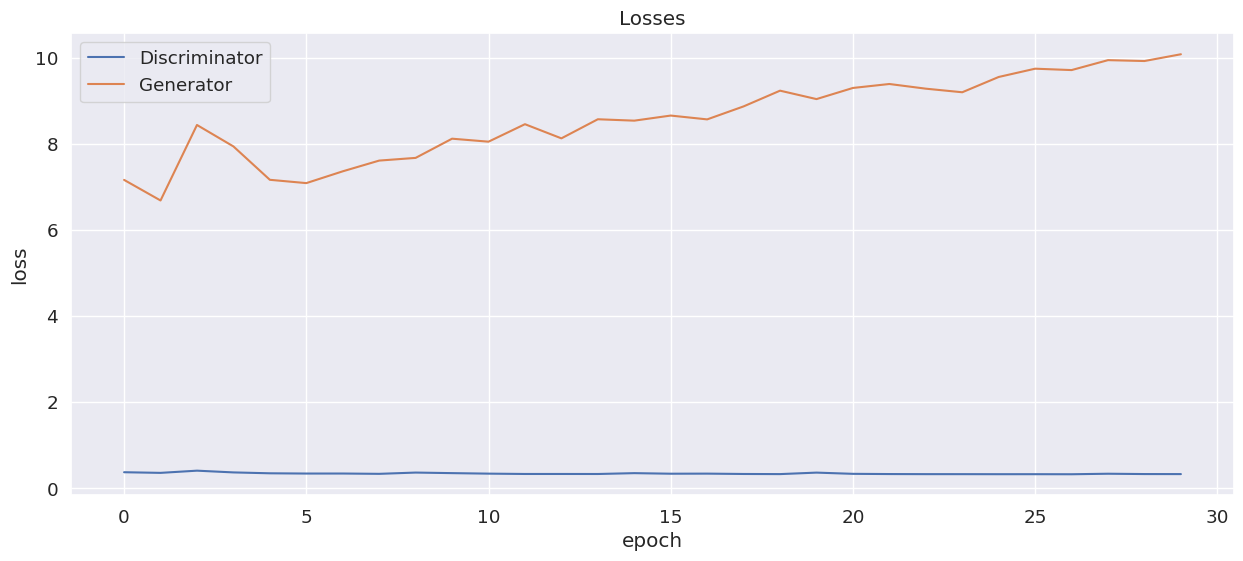

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
from google.colab import drive
import torch

# Укажите путь к файлу на Google Диске, куда хотите сохранить модель
path = '/content/drive/MyDrive/model_GAN_Faces_generator_new_v1.h5'

# Сохранение модели
torch.save(model["generator_new"].state_dict(), path)

print("Модель generator успешно сохранена на Google Диск по пути:", path)

Модель generator успешно сохранена на Google Диск по пути: /content/drive/MyDrive/model_GAN_Faces_generator_new_v1.h5


In [ ]:
# Укажите путь и имя файла для сохранения модели
path = '/content/drive/MyDrive/model_GAN_Faces_generator_new_v1.pth'
# Сохранение модели
torch.save(model["generator_new"].state_dict(), path)

In [ ]:
# Укажите путь к файлу на Google Диске, куда хотите сохранить модель
path = '/content/drive/MyDrive/model_GAN_Faces_discriminator_new_v1.h5'

# Сохранение модели
torch.save(model["discriminator_new"].state_dict(), path)

print("Модель discriminator успешно сохранена на Google Диск по пути:", path)

Модель discriminator успешно сохранена на Google Диск по пути: /content/drive/MyDrive/model_GAN_Faces_discriminator_new_v1.h5


In [ ]:
# Укажите путь и имя файла для сохранения модели
path = '/content/drive/MyDrive/model_GAN_Faces_discriminator_new_v1.pth'
# Сохранение модели
torch.save(model["discriminator_new"].state_dict(), path)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images = 1

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
generated_img = model["generator_new"](fixed_latent)

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_images(generated):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])

    # Нормализация значений пикселей к диапазону [0, 1]
    normalized_img = vutils.make_grid(generated, normalize=True)

    ax.imshow(normalized_img.permute(1, 2, 0).cpu().detach().numpy())
    plt.show()